Esse é o código referente a análise de imagens.

Instale as bibliotecas importadas abaixo e sempre comente as mudanças feitas para versionamento.

Os tópicos de 5 a 10 não estão sendo utilizados efetivamente, são testes para filtros diferentes!

# 1) Importações

## 1.1 Módulos e Bibliotecas

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from pandas import DataFrame as df

import matplotlib.pyplot as plt

from skimage import measure, io, img_as_ubyte
from skimage.color import label2rgb, rgb2gray

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

ModuleNotFoundError: No module named 'cv2'

## 1.2 Imagem

cv.imread: https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

In [ ]:
# file information
ImgFile = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/bandeja3.jpg'

# read image
src1 = cv.imread(ImgFile,1)                             #Colorida
src0 = cv.imread(ImgFile,0)                             #grayscale

# show original image
print("Image 1")
cv2_imshow(src1)
print("Image 0")
cv2_imshow(src0)

# 2) Função - Recortar Foto

## 2.1 Aplicação dos filtros

Open.cv: https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html 

cv.dilate: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

cv.medianBlur: https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9

cv.absdiff: https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga6fef31bc8c4071cbc114a758a2b79c14 

cv.normalize: https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

cv.merge: https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga7d7b4d6c6ee504b30a20b1680029c7b4

cv.threshold: https://docs.opencv.org/4.5.2/d7/d4d/tutorial_py_thresholding.html

Otsu's thresholding: https://learnopencv.com/otsu-thresholding-with-opencv/

In [ ]:
rgb_planes = cv.split(src0)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv.dilate(plane, np.ones((10,10), np.uint8))
    bg_img = cv.medianBlur(dilated_img, 21)
    diff_img = 255 - cv.absdiff(plane, bg_img)
    norm_img = cv.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv.merge(result_planes)
result_norm = cv.merge(result_norm_planes)

maxValue = 255
retval, dst = cv.threshold(result, 0, maxValue, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# show image with edges
print("Edges Filter")
cv2_imshow(dst)

## 2.2 Localizar os círculos

cv.HoughCircles: https://medium.com/turing-talks/houghcircles-detec%C3%A7%C3%A3o-de-c%C3%ADrculos-em-imagens-com-opencv-e-python-2d229ad9d43b 

In [ ]:
# Achar os círculos
circles = cv.HoughCircles(dst,
                          cv.HOUGH_GRADIENT,
                          dp=1.2,
                          minDist=200,
                          param1=200,
                          param2=8,
                          minRadius=85,
                          maxRadius=90)
# Mudar para inteiro
circles = np.uint16(np.around(circles))
print(circles)

In [ ]:
# Save circles coordinates in a list of tuples(center)
group='A'
center = []
for i in circles[0,:]:
    center.append([i[0],i[1], i[2]])
# treat circles with pandas dataframe 
df = pd.DataFrame(center, columns=['x','y','radius'])
# order circles by x position and limit result to 16 circles (this will exclude the other circles)
df = df.sort_values(by='x').reset_index(drop=True).head(n=16) 
# creates group_index
df['group_index'] = str(group)
# creates cell_index
df = df.sort_values(by=['group_index', 'y'])
df['cell_index'] = range(1, 17)


# show circles information
print(df)

Image With Circles


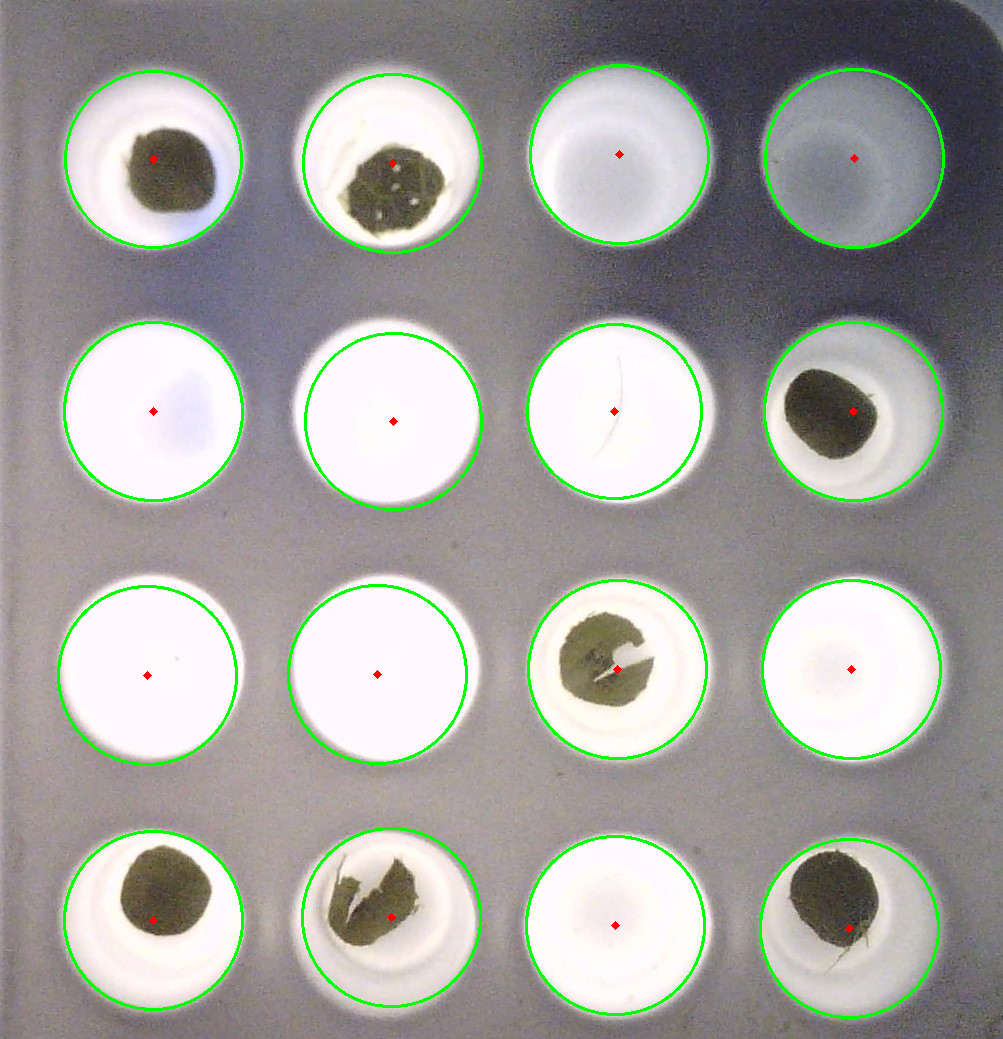

In [ ]:
# desenhar os círculos na imagem
circles_image = src1.copy()
for index, row in df.iterrows():
    # desenhar a borda do círculo
    cv.circle(circles_image,(df.x[index],df.y[index]),
              df.radius[index],(0,255,0),2)
    # desenhar o centro do círculo
    cv.circle(circles_image,(df.x[index],df.y[index]),2,(0,0,255),3)
# exibir imagem com círculos
print("Image With Circles")
cv2_imshow(circles_image)

## 2.3 Divisão da Imagem

In [ ]:
for index, row in df.iterrows():
  # crop image
  image = src1[(df.y[index]-100):(df.y[index]+100),(df.x[index]-100):(df.x[index]+100)]
  # save image
  image_name = str(df.group_index[index])+str(df.cell_index[index])+'.jpg'
  cv.imwrite('/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'+image_name, image) 
  # show images
  print(image_name)
  cv2_imshow(image)

# 3) Análise da Figura - Algoritmo Luciano

## 3.1 Função - Fundo e Área

In [ ]:
def Leaf_area(bg, leaf, leaf_gray):
  # blur background image
  bg_blur = cv.blur(bg,(10,10))

  # Remove background from image using MOG
  fgbg = cv.bgsegm.createBackgroundSubtractorMOG()

  fg1 = fgbg.apply(bg_blur)
  fb2 = fgbg.apply(leaf_gray)

  fgmask = fgbg.apply(leaf_gray)

  #remove mask from leaf
  leaf_no_bg = cv.bitwise_and(leaf, leaf, mask=fgmask)

  #apply filter
  # enhance leaf image
  leaf_enhance = cv.detailEnhance(leaf_no_bg, sigma_s=10, sigma_r=0.15)

  hsv = cv.cvtColor(leaf_enhance, cv.COLOR_BGR2HSV)

  #set the bounds for blue 
  lower_red = np.array([10,10,10])
  upper_red = np.array([200,255,255])

  #create a mask using the bounds set
  filter_mask = cv.inRange(hsv, lower_red, upper_red)

  #remove mask from leaf
  leaf_no_bg_filtered = cv.bitwise_and(leaf_no_bg, leaf_no_bg, mask=filter_mask)

  #count white pixels to find leaf area
  leaf_area_px = np.sum(fgmask == 255)
  px_to_mm = 0.00781
  leaf_area_mm2 = leaf_area_px*px_to_mm 

  print("Original image")
  cv2_imshow(leaf)
  print("Background")
  cv2_imshow(bg_blur)
  #print("Mask")
  #cv2_imshow(fgmask)
  print("Image with no background")
  cv2_imshow(leaf_no_bg)
  #print("Leaf enhance")
  #cv2_imshow(hsv)
  print("Leaf Filtered")
  cv2_imshow(leaf_no_bg_filtered)

  print('\n\nLeaf Area in Pixels:' , leaf_area_px, 'px')
  print('Aproximate Leaf Area in mm2:', round(leaf_area_mm2,1), 'mm^2')
  print('')
  print('='*100)

## 3.2 Importar a imagem 

In [ ]:
file_name_bg = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/A11.jpg'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
group = 'A'

## 3.3 Executa a Função

In [ ]:
# read image
for i in range(1,17):
  leaf_index=group+str(i)
  background_gray = cv.imread(file_name_bg,0)
  leaf_gray = cv.imread(file_path+leaf_index+'.jpg',0)
  leaf = cv.imread(file_path+leaf_index+'.jpg',1)

  Leaf_area(background_gray, leaf, leaf_gray)

# 4) Análise da Figura - Algoritmo Caio

## 4.1 Função - Análise da Área

In [ ]:
def main(cell):
  file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
  arquivo = file_path + cell + ".jpg"
  image = cv.imread(arquivo,1)
  image_gray = cv.imread(arquivo,0)

  # Threshold
  threshold = threshold_otsu(image_gray)
  thresholded_img = image < threshold
  # Labels
  label_image = measure.label(thresholded_img,
                              connectivity = image.ndim)

  all_props = measure.regionprops(label_image, image)
  #Can print various parameters for all objects
  for prop in all_props:
    # print('Label: {} Area: {}'.format(prop.label, prop.area))
    props = measure.regionprops_table(label_image, image, 
                          properties=['label',
                                      'area', 'equivalent_diameter'])
  
  scale = 0.6
  df2 = pd.DataFrame(props)
  # Converter em escala micron
  df2['equivalent_diameter_microns'] = df2['equivalent_diameter'] * (scale)
  df2['area_sq_microns'] = df2['area'] * (scale**2)

  del df2['equivalent_diameter']
  # del df2['area']
  # Filtrar áreas
  df2.drop(df2[df2.area < 200].index, inplace=True) # grãos
  # df.drop(df[df.area > 7000].index, inplace=True) # bandeja
  df2['Cell'] = cell
  total_area = df2.area.sum()
  return total_area

## 4.2 Executa a Função

In [ ]:
# read image
lista=[]
cells=[]
for i in range(1,17):
  leaf_index=group+str(i)
  area = main(leaf_index)
  lista.append(area)
  cells.append(leaf_index)

df = pd.DataFrame()
df['Cell']=cells
df['Área']=lista

display(df)

# 5) Análise da Figura - Filtro de Mancha

Código: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

np.stack: https://numpy.org/doc/stable/reference/generated/numpy.stack.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed, hed2rgb

# Load Image
cell = 'A6'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
arquivo = file_path + cell + ".jpg"
Image_RGB = cv.imread(arquivo,1)

# Separate the stains from the image
Image_HED = rgb2hed(Image_RGB)

# Create an RGB image for each of the stains
null = np.zeros_like(Image_HED[:,:,0])
Image_HR = hed2rgb(np.stack((Image_HED[:, :, 0], null, null), axis=-1))
Image_EG = hed2rgb(np.stack((null, Image_HED[:, :, 1], null), axis=-1))
Image_DB = hed2rgb(np.stack((null, null, Image_HED[:, :, 2]), axis=-1))
null2 = np.zeros_like(Image_RGB[:,:,0])
Image_R = (np.stack((Image_RGB[:, :, 0], null2, null2), axis=-1))
Image_G = (np.stack((null2, Image_RGB[:, :, 1], null2), axis=-1))
Image_B = (np.stack((null2, null2, Image_RGB[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(Image_HED)
ax[0].set_title("Original Image - HED")

ax[1].imshow(Image_HR)
ax[1].set_title("HED Filter Image - H")

ax[2].imshow(Image_EG)
ax[2].set_title("HED Filter Image - E")

ax[3].imshow(Image_DB)
ax[3].set_title("HED Filter Image - D")

ax[4].imshow(Image_RGB)
ax[4].set_title("Original Image - RGB")

ax[5].imshow(Image_R)
ax[5].set_title("RGB Filter Image - R")

ax[6].imshow(Image_G)
ax[6].set_title("RGB Filter Image - G")

ax[7].imshow(Image_B)
ax[7].set_title("RGB Filter Image - B")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

# 6) Análise da Figura - Color Spaces

Image Segmentation: https://realpython.com/python-opencv-color-spaces/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
len(flags)
flags[40]

In [ ]:
# Load Image
cell = 'A6'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
arquivo = file_path + cell + ".jpg"
image = cv.imread(arquivo)
print("Imagem importada")
plt.imshow(image)
plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Imagem BGR2RGB")
plt.imshow(image)
plt.show()

In [ ]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

light_green = (77,66,29)
dark_green = (83,55,27)

mask = cv2.inRange(hsv_image, light_green, dark_green)
result = cv2.bitwise_and(image, image, mask=mask)

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

In [ ]:
blur = cv2.GaussianBlur(result, (7, 7), 0)
plt.imshow(blur)
plt.show()

# 7) Análise da Figura - Irregular Area

Tutorial: https://stackoverflow.com/questions/64394768/how-calculate-the-area-of-irregular-object-in-an-image-opencv-python-3-8

In [ ]:
import cv2
import numpy as np
import math

# input image
cell = 'A6'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
path = file_path + cell + ".jpg"
# 1 EUR coin diameter in cm
coinDiameter = 2.325
# real area for the coin in cm^2
coinArea = (coinDiameter/2)**2 * math.pi
# initializing the multiplying factor for real size
realAreaPerPixel = 1


# pixel to cm^2
def pixelToArea(objectSizeInPixel, coinSizeInPixel):
    # how many cm^2 per pixel?
    realAreaPerPixel = coinArea / coinSizeInPixel
    print("realAreaPerPixel: ", realAreaPerPixel)
    # object area in cm^2
    objectArea = realAreaPerPixel * objectSizeInPixel
    return objectArea    


# finding coin and steak contours
def getContours(img, imgContour):
    
    # find all the contours from the B&W image
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # needed to filter only our contours of interest
    finalContours = []
    
    # for each contour found
    for cnt in contours:
        # cv2.drawContours(imgContour, cnt, -1, (255, 0, 255), 2)
        # find its area in pixel
        area = cv2.contourArea(cnt)
        print("Detected Contour with Area: ", area)

        # minimum area value is to be fixed as the one that leaves the coin as the small object on the scene
        if (area > 5000):
            perimeter = cv2.arcLength(cnt, True)
            
            # smaller epsilon -> more vertices detected [= more precision]
            epsilon = 0.002*perimeter
            # check how many vertices         
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            #print(len(approx))
            
            finalContours.append([len(approx), area, approx, cnt])

    # we want only two objects here: the coin and the meat slice
    print("---\nFinal number of External Contours: ", len(finalContours))
    # so at this point finalContours should have only two elements
    # sorting in ascending order depending on the area
    finalContours = sorted(finalContours, key = lambda x:x[1], reverse=False)
    
    # drawing contours for the final objects
    for con in finalContours:
        cv2.drawContours(imgContour, con[3], -1, (0, 0, 255), 3)

    return imgContour, finalContours

    
# sourcing the input image
img = cv2.imread(path)
print("Starting image")
cv2_imshow(img)
cv2.waitKey()

# blurring
imgBlur = cv2.GaussianBlur(img, (7, 7), 1)
# graying
imgGray = cv2.cvtColor(imgBlur, cv2.COLOR_BGR2GRAY)
# canny
imgCanny = cv2.Canny(imgGray, 255, 195)

kernel = np.ones((2, 2))
imgDil = cv2.dilate(imgCanny, kernel, iterations = 3)
# cv2.imshow("Diluted", imgDil)
imgThre = cv2.erode(imgDil, kernel, iterations = 3)

imgFinalContours, finalContours = getContours(imgThre, img)

# first final contour has the area of the coin in pixel
coinPixelArea = finalContours[0][1]
print("Coin Area in pixel", coinPixelArea)

# show  the contours on the unfiltered starting image
print("Final External Contours")
cv2_imshow(imgFinalContours)
cv2.waitKey()


# now let's detect and quantify the lean part

# convert to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
# set lower and upper color limits
lowerVal = np.array([0, 159, 160])
upperVal = np.array([101, 255, 253])
# Threshold the HSV image to get only red colors
mask = cv2.inRange(hsv, lowerVal, upperVal)
# apply mask to original image - this shows the red with black blackground
final = cv2.bitwise_and(img, img, mask= mask)

# show selection
print("Lean Cut")
cv2_imshow(final)
cv2.waitKey()

# convert it to grayscale because countNonZero() wants 1 channel images
gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
# cv2.imshow("Gray", gray)
# cv2.waitKey()
meatyPixelArea = cv2.countNonZero(gray)

print("Red Area in pixel: ", meatyPixelArea)
print("Red Area in cm^2: ", pixelToArea(meatyPixelArea, coinPixelArea))

cv2.destroyAllWindows()

# 8) Análise da Figura - Blob Detection

Tutorial: https://www.youtube.com/watch?v=2puHfSKnG7c 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# input image
cell = 'A6'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
path = file_path + cell + ".jpg"
# The input image.
image = cv2.imread(path, 0)
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
#image=image[:,:,0] 

#No need to pre-threshold as blob detector has build in threshold.
#We can supply a pre-thresholded image.

# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Define thresholds
#Can define thresholdStep. See documentation. 
params.minThreshold = 0
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 500
params.maxArea = 10000

# Filter by Color (black=0)
params.filterByColor = False  #Set true for cast_iron as we'll be detecting black regions
params.blobColor = 0

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
params.maxConvexity = 1

# Filter by InertiaRatio
params.filterByInertia = True
params.minInertiaRatio = 0
params.maxInertiaRatio = 1

# Distance Between Blobs
params.minDistBetweenBlobs = 0

# Setup the detector with parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(image)

print("Number of blobs detected are : ", len(keypoints))


# Draw blobs
img_with_blobs = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_with_blobs)
print("Keypoints")
cv2_imshow(img_with_blobs)

# Save result
#cv2.imwrite("particle_blobs.jpg", img_with_blobs)

# 9) Análise da Figura - MASK R-CNN

Tutorial: https://www.youtube.com/watch?v=8m8m4oWsp8M

In [ ]:
import cv2
import numpy as np

# Loading Mask RCNN
net = cv2.dnn.readNetFromTensorflow("/content/drive/MyDrive/Colab Notebooks/TCC/dnn/frozen_inference_graph_coco.pb",
									"/content/drive/MyDrive/Colab Notebooks/TCC/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

# Generate random colors
colors = np.random.randint(0, 255, (80, 3))

print(colors)

# Load image
cell = 'A6'
file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
path = file_path + cell + ".jpg"
img = cv2.imread(path)
height, width, _ = img.shape

# Create black image
black_image = np.zeros((height, width, 3), np.uint8)
black_image[:] = (100, 100, 0)

# Detect objects
blob = cv2.dnn.blobFromImage(img, swapRB=True)
net.setInput(blob)

boxes, masks = net.forward(["detection_out_final", "detection_masks"])
detection_count = boxes.shape[2]

for i in range(detection_count):
	box = boxes[0, 0, i]
	class_id = box[1]
	score = box[2]
	if score < 0.5:
		continue

	# Get box Coordinates
	x = int(box[3] * width)
	y = int(box[4] * height)
	x2 = int(box[5] * width)
	y2 = int(box[6] * height)

	roi = black_image[y: y2, x: x2]
	roi_height, roi_width, _ = roi.shape

	# Get the mask
	mask = masks[i, int(class_id)]
	mask = cv2.resize(mask, (roi_width, roi_height))
	_, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

	cv2.rectangle(img, (x, y), (x2, y2), (255, 0, 0), 3)

	# Get mask coordinates
	contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	color = colors[int(class_id)]
	for cnt in contours:
		cv2.fillPoly(roi, [cnt], (int(color[0]), int(color[1]), int(color[2])))

	# cv2.imshow("roi", roi)
	# cv2.waitKey(0)

print("Image")
cv2_imshow(img)
print("Black image")
cv2_imshow(black_image)

# 10) Análise da Figura - Color segmentation

Tutorial: https://www.youtube.com/watch?v=efWITgemKvs

In [ ]:
import cv2
import numpy as np

lowerBound=np.array([33,80,40])
upperBound=np.array([102,255,255])

cam= cv2.VideoCapture(0)
kernelOpen=np.ones((5,5))
kernelClose=np.ones((20,20))

font=cv2.cv.InitFont(cv2.cv.CV_FONT_HERSHEY_SIMPLEX,2,0.5,0,3,1)

while True:
    ret, img=cam.read()
    img=cv2.resize(img,(340,220))

    #convert BGR to HSV
    imgHSV= cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    # create the Mask
    mask=cv2.inRange(imgHSV,lowerBound,upperBound)
    #morphology
    maskOpen=cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernelOpen)
    maskClose=cv2.morphologyEx(maskOpen,cv2.MORPH_CLOSE,kernelClose)

    maskFinal=maskClose
    conts,h=cv2.findContours(maskFinal.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    
    cv2.drawContours(img,conts,-1,(255,0,0),3)
    for i in range(len(conts)):
        x,y,w,h=cv2.boundingRect(conts[i])
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255), 2)
        cv2.cv.PutText(cv2.cv.fromarray(img), str(i+1),(x,y+h),font,(0,255,255))
    cv2_imshow("maskClose",maskClose)
    cv2_imshow("maskOpen",maskOpen)
    cv2_imshow("mask",mask)
    cv2_imshow("cam",img)

# 11) Laços de Repetição

In [ ]:
#Valores para edição
bioassay = 9895
path = '/Bayer/Resultados_Bioassay/'

#Define os grupos
group_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

#Percorre os paths de fotos dos grupos
for group in group_list:
  group_path = path+str(bioassay)+'/Fotos_Originais/'+str(bioassay)+'_Grupo_'+group
  print(group_path)

#Linha de separação
print()
print("*"*100)
print()

#Percorre os paths de fotos das folhas cortadas
for group in group_list:
  for i in range(1,17):
    img_path = path+str(bioassay)+'/Fotos_Cortadas/'+str(bioassay)+'_Foto_'+group+str(i)
    print(img_path)

# 12) Realizar Teste

In [ ]:
def Capturar_Imagens():
  pass

def Cortar_Imagens(group_path):
  pass
  
def Analisar_Imagens(img_path):
  return True

In [ ]:
#Valores para edição
bioassay = 9895
path = '/Bayer/Resultados_Bioassay/'

#Define os grupos
group_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

#Execução da Função de Captura das Imagens
Capturar_Imagens()

#Execução da Função de Corte das Imagens
for group in group_list:
  group_path = path+str(bioassay)+'/Fotos_Originais/'+str(bioassay)+'_Grupo_'+group
  Cortar_Imagens(group_path)

#Execução da Função de Análise das Imagens
ListGroup = []
ListCell = []
ListArea = []
for group in group_list:
  for i in range(1,17):
    img_path = path+str(bioassay)+'/Fotos_Cortadas/'+str(bioassay)+'_Foto_'+group+str(i)
    img_area = Analisar_Imagens(img_path)
    ListArea.append(img_area)
    ListCell.append(i)
    ListGroup.append(group)

df = pd.DataFrame()
df['Group'] = ListGroup
df['Cell'] = ListCell
df['Área'] = ListArea

display(df)

# 13) CSV

In [ ]:
from datetime import datetime
db_final = pd.DataFrame()

db_final['Data início'] = [datetime.now().strftime("%d/%m/%Y %H:%M:%S")]
db_final['Data final'] = [datetime.now().strftime("%d/%m/%Y %H:%M:%S")]
db_final['Operador'] = ['Bang']
db_final["Planta"] = ['Soja']
db_final["Cell"] = ['1']
db_final["Groupo_ID"] = "A"
db_final['Cell_ID'] = "1"
db_final['Condição'] = 'Controle'
db_final['Área inicial da planta'] = 100
db_final['Área final da planta'] = 75
db_final['Redução (%)'] = (db_final['Área inicial da planta'] - db_final['Área final da planta']) / db_final['Área inicial da planta'] *100

# lista de condições para nível de redução
conditions1 = [
    (db_final['Redução (%)'] >= 90), (db_final['Redução (%)'] < 90) & (db_final['Redução (%)'] >= 80),
     (db_final['Redução (%)'] < 80) & (db_final['Redução (%)'] >= 70), (db_final['Redução (%)'] < 70) & (db_final['Redução (%)'] >= 60), 
     (db_final['Redução (%)'] < 60) & (db_final['Redução (%)'] >= 50), (db_final['Redução (%)'] < 50) & (db_final['Redução (%)'] >= 40), 
     (db_final['Redução (%)'] < 40) & (db_final['Redução (%)'] >= 30), (db_final['Redução (%)'] < 30) & (db_final['Redução (%)'] >= 20), 
     (db_final['Redução (%)'] < 20) & (db_final['Redução (%)'] >= 10), (db_final['Redução (%)'] < 10)
    ]
# lista de valores para cada condição
values1 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
db_final['Nível de redução'] = np.select(conditions1, values1)

db_final['Tamanho inicial da lagarta'] = 3
db_final['Tamanho final da lagarta'] = 5
db_final['Aumento (%)'] = round((db_final['Tamanho final da lagarta'] / db_final['Tamanho inicial da lagarta'] - 1) *100, 2)

# lista de condições para nível de redução
conditions2 = [(db_final['Aumento (%)'] > 0), (db_final['Aumento (%)'] == 0)]
# lista de valores para cada condição
values2 = ['Viva - 1', 'Morta - 0']
db_final['Status da lagarta'] = np.select(conditions2, values2)
db_final.head()

In [ ]:
import kivy
from kivy.app import App
from kivy.uix.label import Label